In [1]:
pip install dremio-simple-query

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 45.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 100.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.3/32.3 MB 68.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 61.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 13.0.0
    Uninstalling pyarrow-13.0.0:
      Successfully uninstalled pyarrow-13.0.0
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dremio_simple_query.connect import get_token

## URL to Login Endpoint
login_endpoint = "http://172.18.0.1:9047/apiv2/login"

## Payload for Login
## Update with your Dremio credentials
payload = {
    "userName": "admin",
    "password": "password1"
}

## Get token from API
token = get_token(uri = login_endpoint, payload=payload)

In [3]:
from pyarrow import flight
import time

def connect_with_retry(max_attempts=3):
    # Dremio container hostname from logs
    dremio_host = "3e13c2378aa8"
    
    print(f"Attempting to connect to Dremio Flight Service...")
    
    for attempt in range(max_attempts):
        try:
            # Try connection with the container hostname
            flight_uri = f"grpc+tcp://{dremio_host}:32010"
            print(f"\nAttempt {attempt + 1}: Connecting to {flight_uri}")
            
            client = flight.FlightClient(flight_uri)
            
            # Set up authentication headers
            headers = [
                (b'authorization', f"bearer {token}".encode('utf-8'))
            ]
            
            # Test connection with a simple query
            sql = "SELECT 1"
            descriptor = flight.FlightDescriptor.for_command(sql)
            options = flight.FlightCallOptions(headers=headers)
            
            flight_info = client.get_flight_info(descriptor, options=options)
            print("Connection successful!")
            
            return client
            
        except Exception as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            time.sleep(2)  # Wait before retrying
            
            # On last attempt, try with 'dremio' hostname instead
            if attempt == max_attempts - 1:
                try:
                    print("\nTrying with 'dremio' hostname...")
                    flight_uri = "grpc+tcp://dremio:32010"
                    client = flight.FlightClient(flight_uri)
                    flight_info = client.get_flight_info(descriptor, options=options)
                    print("Connection successful using 'dremio' hostname!")
                    return client
                except Exception as e:
                    print(f"Failed with 'dremio' hostname: {e}")
    
    return None

# Try to establish connection
client = connect_with_retry()

if client:
    try:
        # Test query
        sql = """
        SELECT * FROM "@admin"."vw_nyc_combined"
        """
        
        # Set up headers and options
        headers = [
            (b'authorization', f"bearer {token}".encode('utf-8'))
        ]
        options = flight.FlightCallOptions(headers=headers)
        
        # Execute query
        print("\nExecuting test query...")
        descriptor = flight.FlightDescriptor.for_command(sql)
        flight_info = client.get_flight_info(descriptor, options=options)
        reader = client.do_get(flight_info.endpoints[0].ticket, options=options)
        
        # Convert to DataFrame
        df = reader.read_pandas()
        print("\nQuery results:")
        print(df)
        
    except Exception as e:
        print(f"Query execution failed: {e}")
else:
    print("\nFailed to establish connection to Dremio Flight Service")
    
    # Additional debugging information
    print("\nChecking network setup...")
    import subprocess
    
    try:
        # Check if containers can see each other
        !ping -c 1 dremio
        
        # Check Docker network
        !docker network inspect dremio-demo
        
        # Check Dremio container details
        !docker inspect dremio | grep -i "NetworkSettings" -A 20
        
    except Exception as e:
        print(f"Error checking network setup: {e}")

Attempting to connect to Dremio Flight Service...

Attempt 1: Connecting to grpc+tcp://3e13c2378aa8:32010
Connection successful!

Executing test query...

Query results:
       pickup_time pickup_date  passenger_count  trip_distance  fare_amount  \
0         18:20:38  2014-08-18                1            1.8          8.0   
1         16:08:53  2014-08-18                1            2.9         15.0   
2         20:44:34  2014-08-18                1            1.7         10.5   
3         18:46:12  2014-08-18                1            0.9          6.5   
4         22:15:05  2014-08-18                1            1.3          6.5   
...            ...         ...              ...            ...          ...   
999995    14:27:41  2013-08-19                1            3.8         14.0   
999996    19:48:26  2013-08-19                1            4.9         16.0   
999997    21:23:29  2013-08-19                1            1.6          7.0   
999998    19:53:46  2013-08-29          

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print(df.head())  # Display the first few rows
print(df.info())  # Get data types and missing values information
print(df.describe())  # Summary statistics for numerical columns

  pickup_time pickup_date  passenger_count  trip_distance  fare_amount  \
0    18:20:38  2014-08-18                1            1.8          8.0   
1    16:08:53  2014-08-18                1            2.9         15.0   
2    20:44:34  2014-08-18                1            1.7         10.5   
3    18:46:12  2014-08-18                1            0.9          6.5   
4    22:15:05  2014-08-18                1            1.3          6.5   

   trip_amount  total_amount      station                         name  \
0         1.90         11.40  USW00094728  NY CITY CENTRAL PARK, NY US   
1         1.00         16.50  USW00094728  NY CITY CENTRAL PARK, NY US   
2         2.87         14.37  USW00094728  NY CITY CENTRAL PARK, NY US   
3         1.00          9.00  USW00094728  NY CITY CENTRAL PARK, NY US   
4         1.00          8.50  USW00094728  NY CITY CENTRAL PARK, NY US   

         date  awnd  prcp  snow  snwd  tempmax  tempmin  
0  2014-08-18  4.47   0.0   0.0   0.0     81.0     6

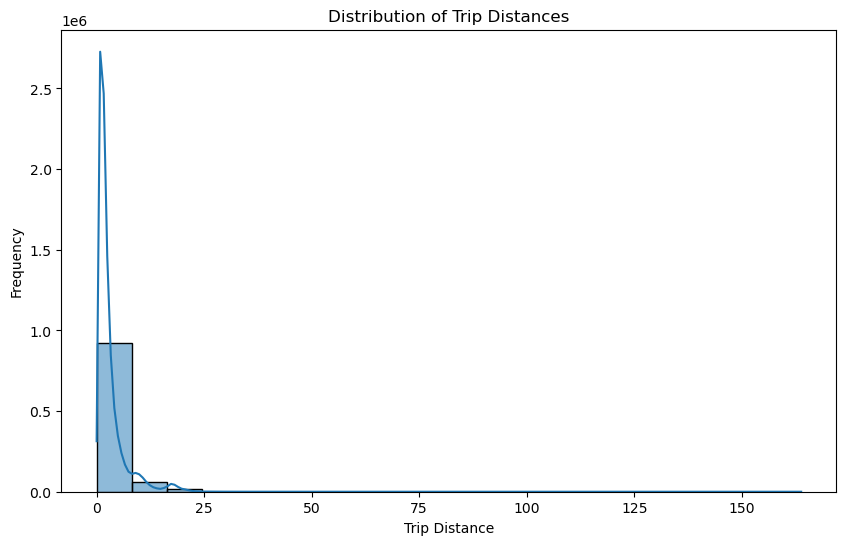

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df['trip_distance'], bins=20, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

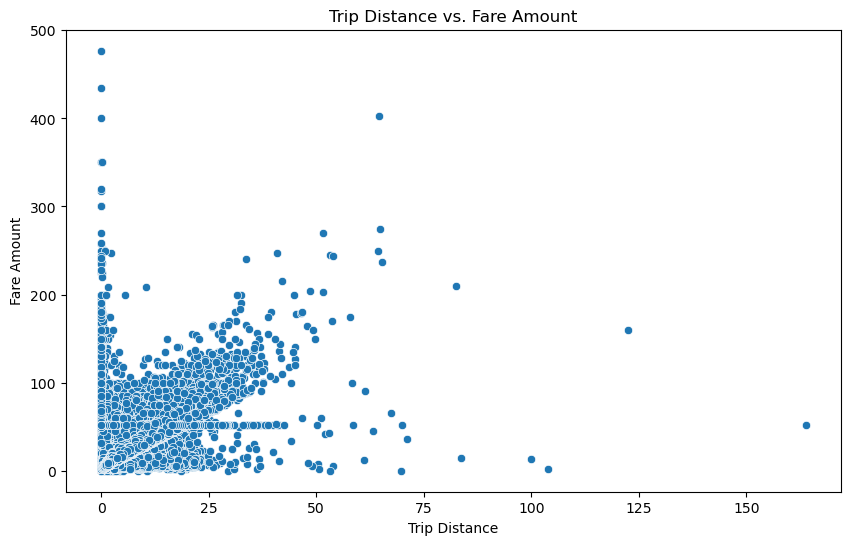

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='fare_amount', data=df)
plt.title('Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


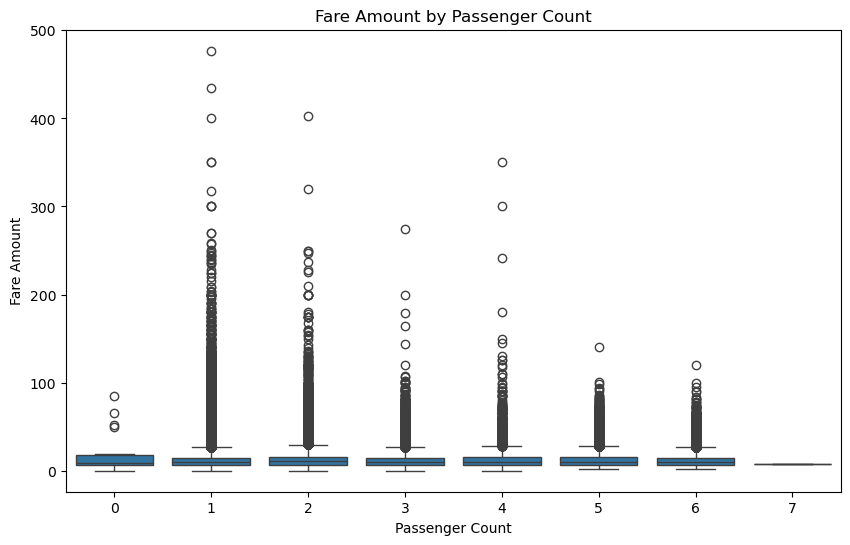

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.show()

In [9]:
numeric_df = df.select_dtypes(include=['number'])

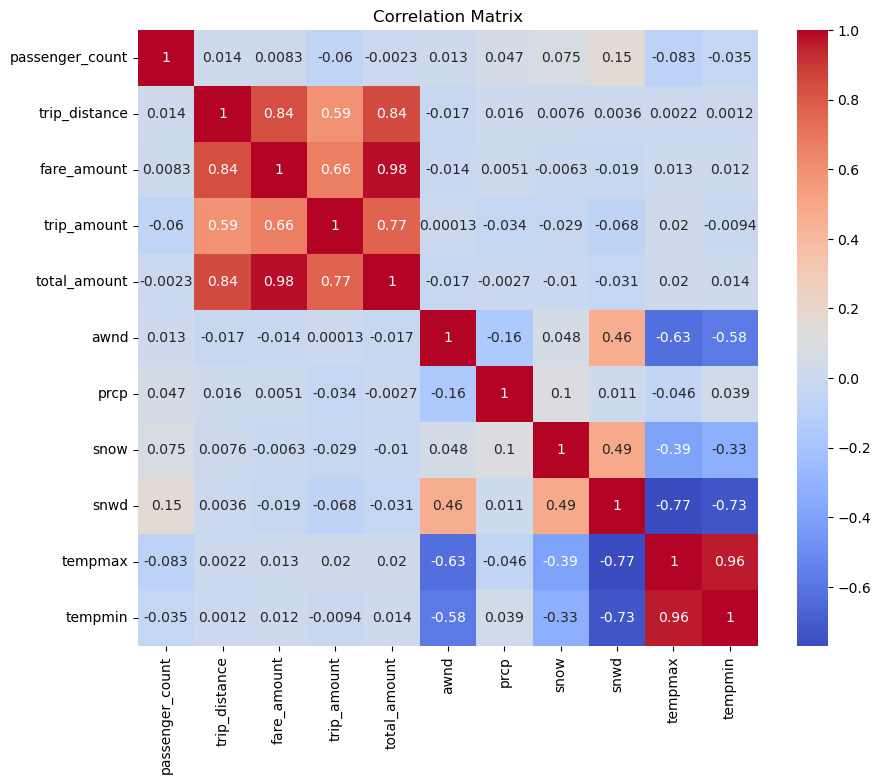

In [10]:
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [11]:
avg_fare_by_passenger = df.groupby('passenger_count')['fare_amount'].mean()
print(avg_fare_by_passenger)

passenger_count
0    20.277778
1    12.957428
2    14.001626
3    13.332065
4    13.553771
5    13.110717
6    12.758886
7     7.500000
Name: fare_amount, dtype: float64


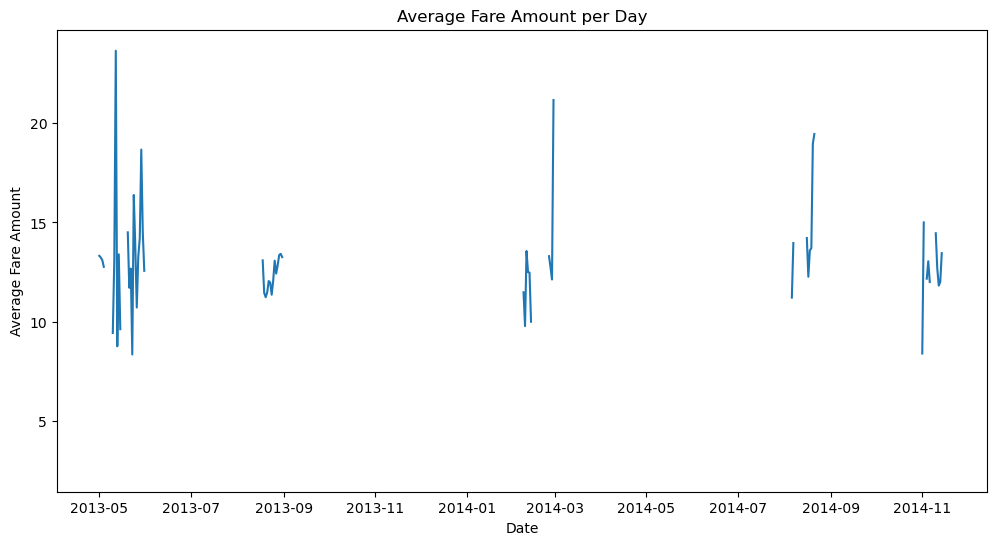

In [12]:
# Convert 'pickup_date' to datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Resample data by day and calculate the average fare
avg_fare_per_day = df.set_index('pickup_date')['fare_amount'].resample('D').mean()

# Plot the trend
plt.figure(figsize=(12, 6))
plt.plot(avg_fare_per_day)
plt.title('Average Fare Amount per Day')
plt.xlabel('Date')
plt.ylabel('Average Fare Amount')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


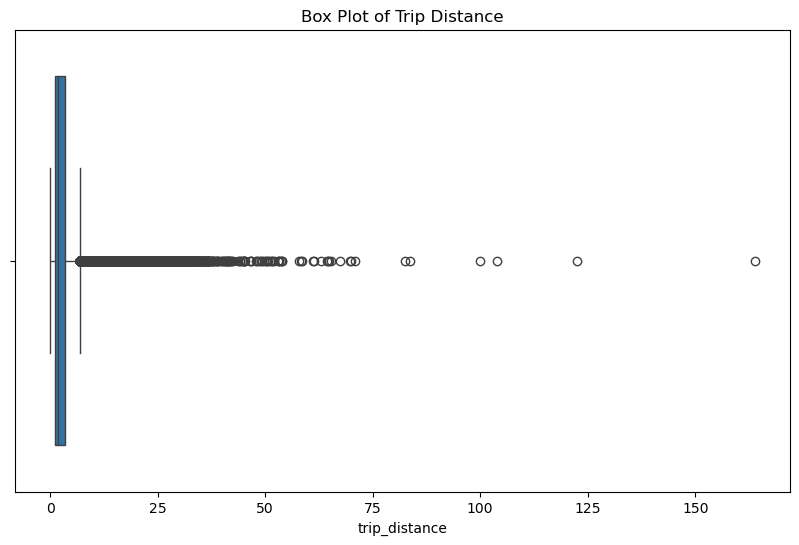

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


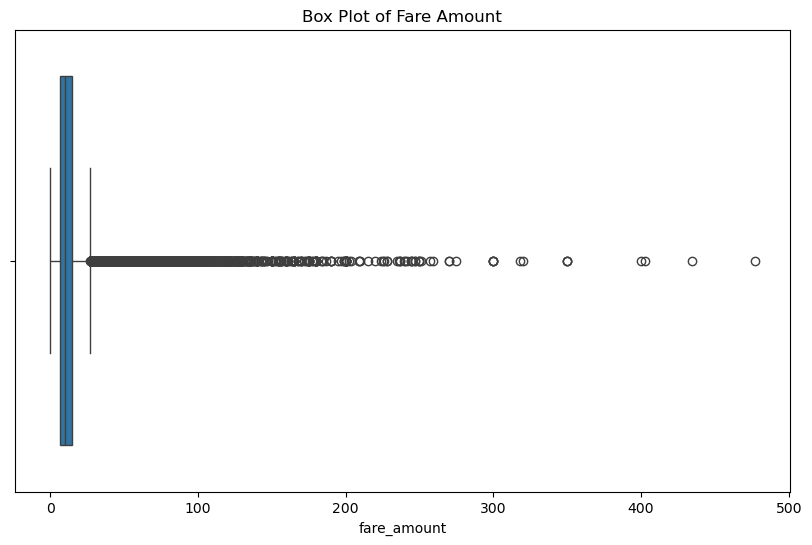

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['fare_amount'])
plt.title('Box Plot of Fare Amount')
plt.show()

In [14]:
df['trip_cost_per_mile'] = df['fare_amount'] / df['trip_distance']

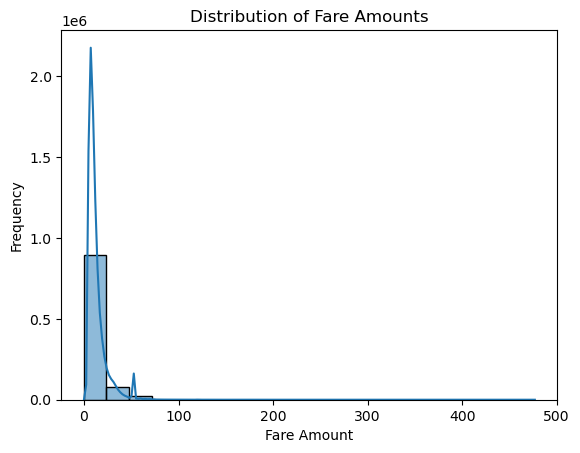

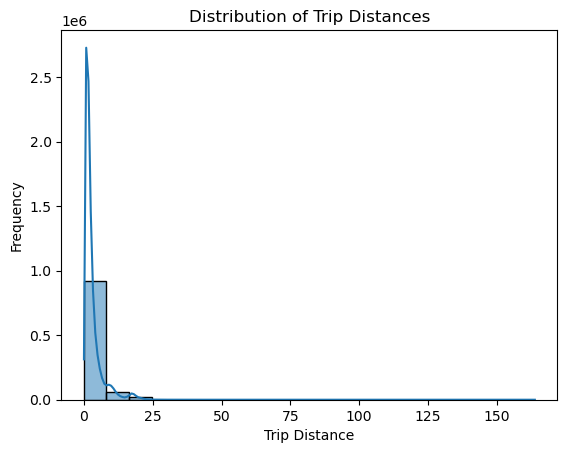

In [15]:
import seaborn as sns

# Visualize the distribution of fare amounts
sns.histplot(df['fare_amount'], bins=20, kde=True)
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

# Analyze the distribution of trip distances
sns.histplot(df['trip_distance'], bins=20, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance')
plt.ylabel('Frequency')
plt.show()

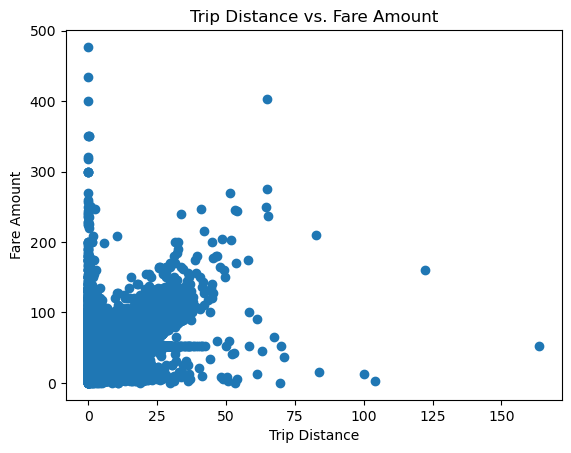

In [16]:
# Explore the relationship between trip distance and fare amount
plt.scatter(df['trip_distance'], df['fare_amount'])
plt.title('Trip Distance vs. Fare Amount')
plt.xlabel('Trip Distance')
plt.ylabel('Fare Amount')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


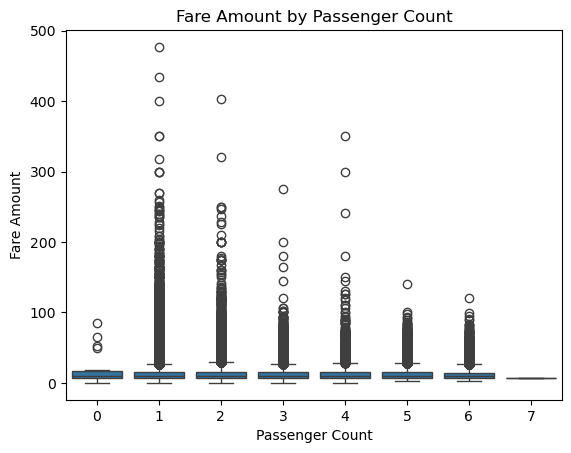

In [17]:
# Compare fare amounts across different passenger counts
sns.boxplot(x='passenger_count', y='fare_amount', data=df)
plt.title('Fare Amount by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Fare Amount')
plt.show()

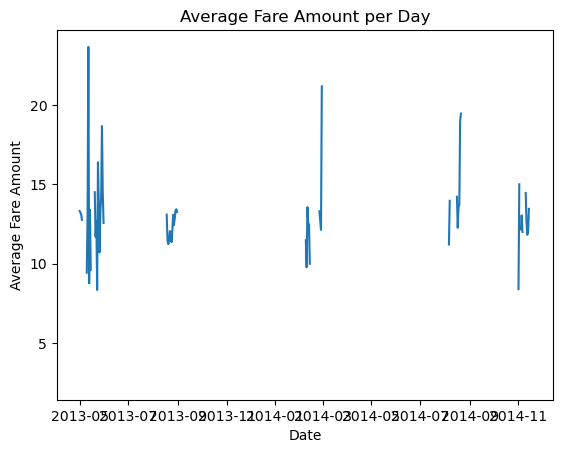

In [18]:
# Convert 'pickup_date' to datetime format
df['pickup_date'] = pd.to_datetime(df['pickup_date'])

# Resample data by day and calculate the average fare
avg_fare_per_day = df.set_index('pickup_date')['fare_amount'].resample('D').mean()

# Plot the trend
plt.plot(avg_fare_per_day)
plt.title('Average Fare Amount per Day')
plt.xlabel('Date')
plt.ylabel('Average Fare Amount')
plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Select features
features = ['trip_distance', 'passenger_count', 'awnd', 'prcp', 'tempmax']
target = 'fare_amount'
X = df[features]
y = df[target]

# Handle missing values (replace with the mean for simplicity)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
from sklearn.linear_model import LinearRegression

# Initialize the model
model = LinearRegression()

In [21]:
# Train the model
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# Make predictions
y_pred = model.predict(X_test)

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 32.30602998977815
R-squared: 0.7094201577694345


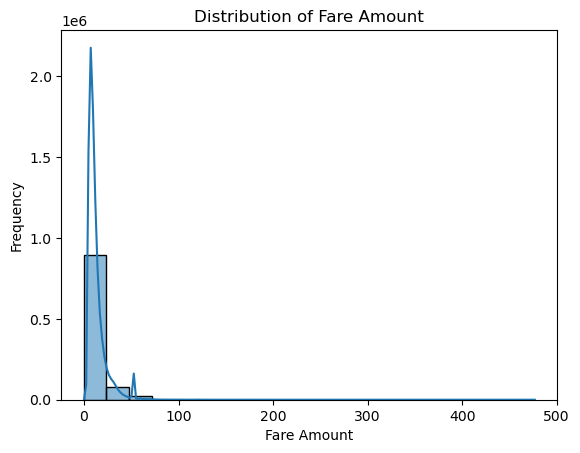

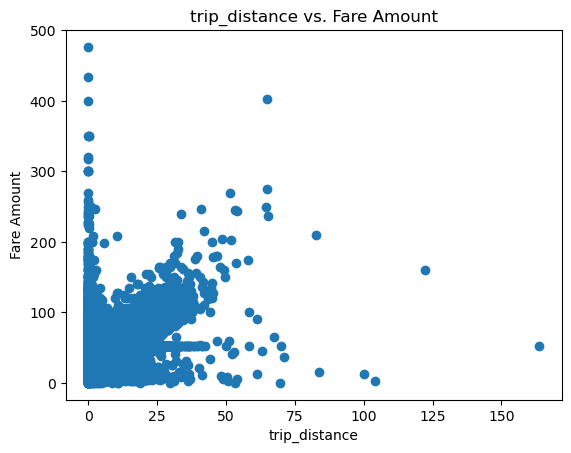

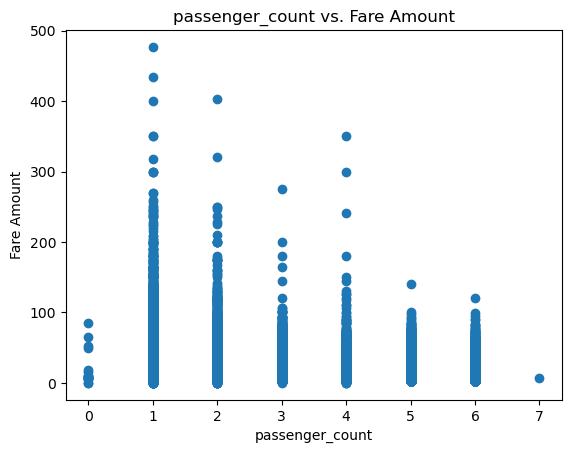

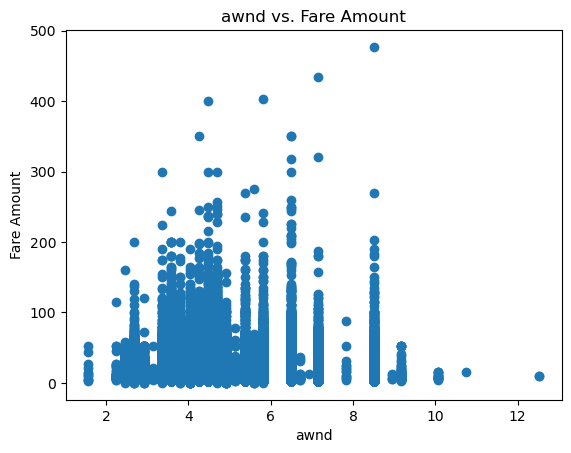

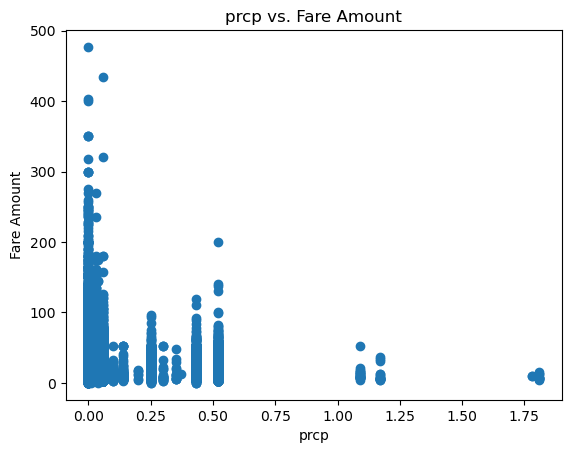

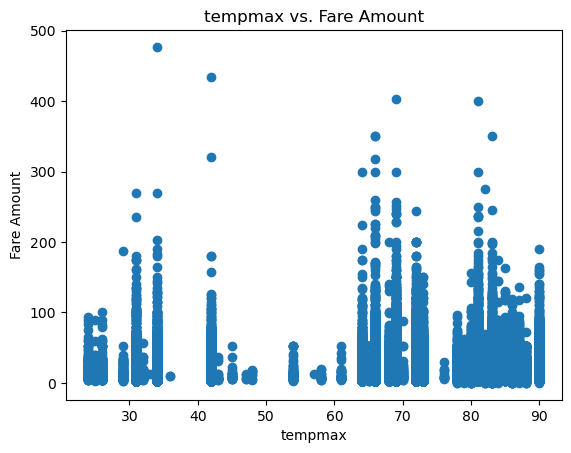

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Select features
features = ['trip_distance', 'passenger_count', 'awnd', 'prcp', 'tempmax']
target = 'fare_amount'
X = df[features]
y = df[target]

# Handle missing values (replace with the mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the distribution of the target variable
sns.histplot(y, bins=20, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between features and target
for i, feature in enumerate(features):  # Use enumerate to get both index and feature name
    plt.scatter(X[:, i], y)  # Access column by index i
    plt.title(f'{feature} vs. Fare Amount')
    plt.xlabel(feature)
    plt.ylabel('Fare Amount')
    plt.show()

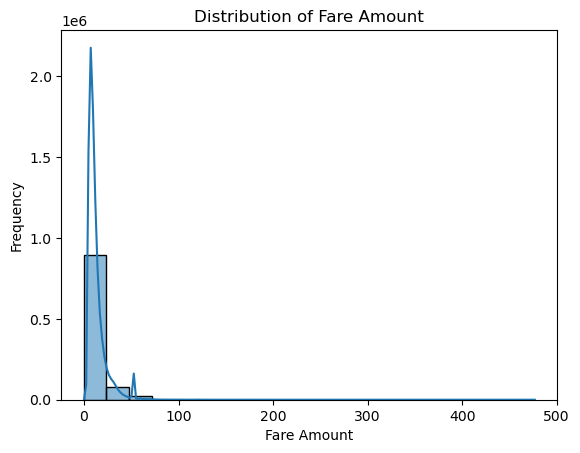

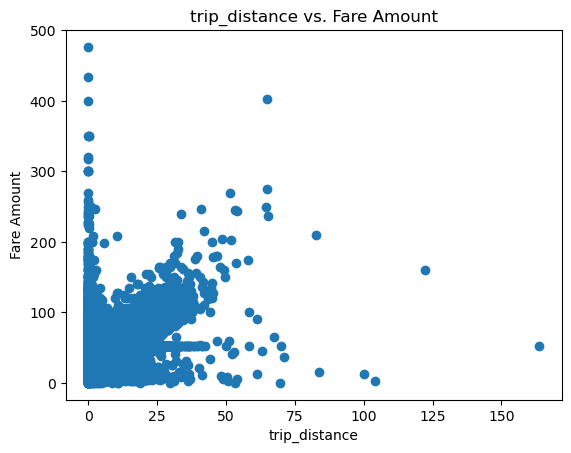

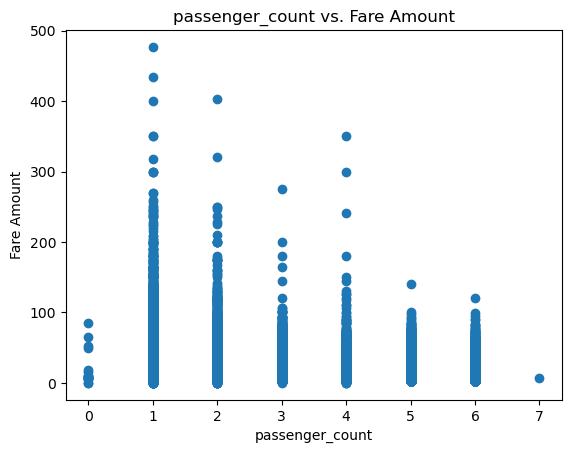

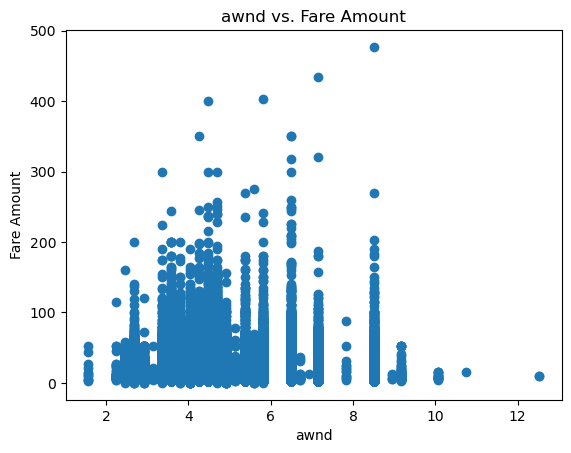

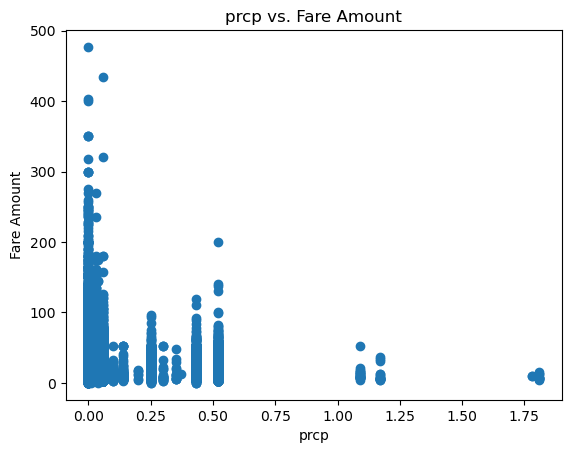

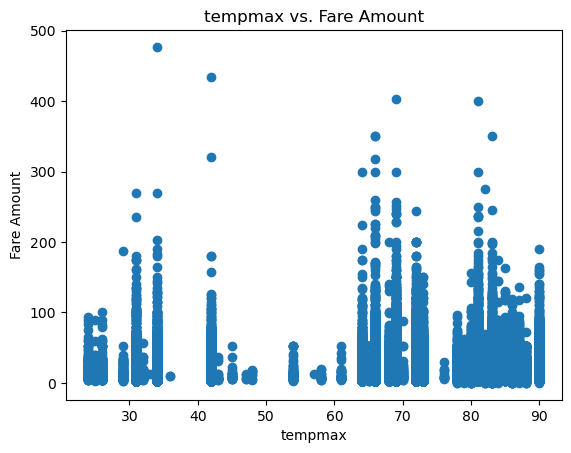

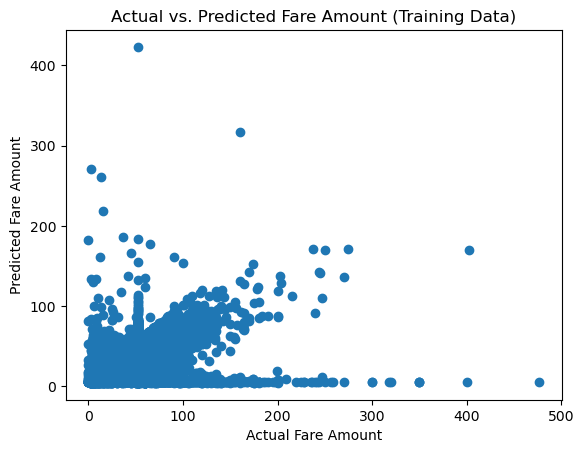

Mean Squared Error: 32.30602998977815
R-squared: 0.7094201577694345


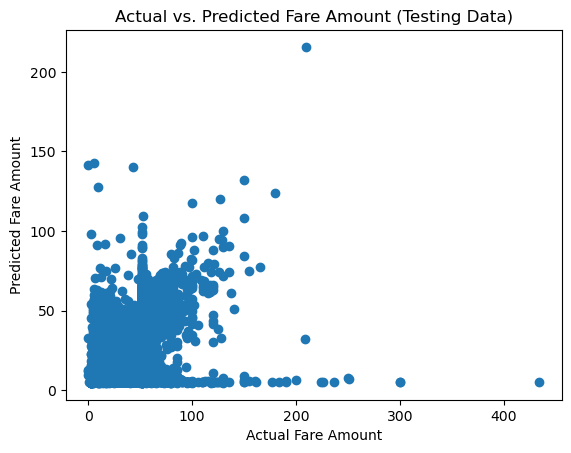

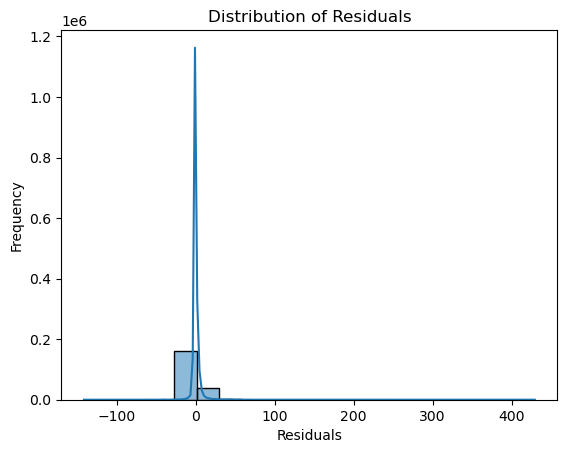

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Select features
features = ['trip_distance', 'passenger_count', 'awnd', 'prcp', 'tempmax']
target = 'fare_amount'
X = df[features]
y = df[target]

# Handle missing values (replace with the mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the distribution of the target variable
sns.histplot(y, bins=20, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between features and target
for i, feature in enumerate(features):
    plt.scatter(X[:, i], y)
    plt.title(f'{feature} vs. Fare Amount')
    plt.xlabel(feature)
    plt.ylabel('Fare Amount')
    plt.show()

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Visualize the model's predictions on the training data
plt.scatter(y_train, model.predict(X_train))
plt.title('Actual vs. Predicted Fare Amount (Training Data)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize the model's predictions on the testing data
plt.scatter(y_test, y_pred)
plt.title('Actual vs. Predicted Fare Amount (Testing Data)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

# Visualize the residuals
residuals = y_test - y_pred
sns.histplot(residuals, bins=20, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

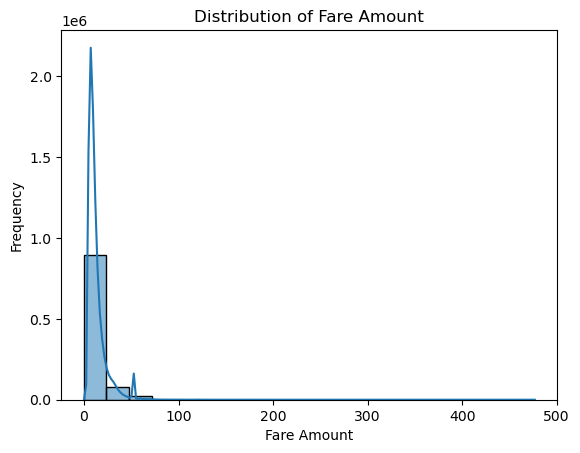

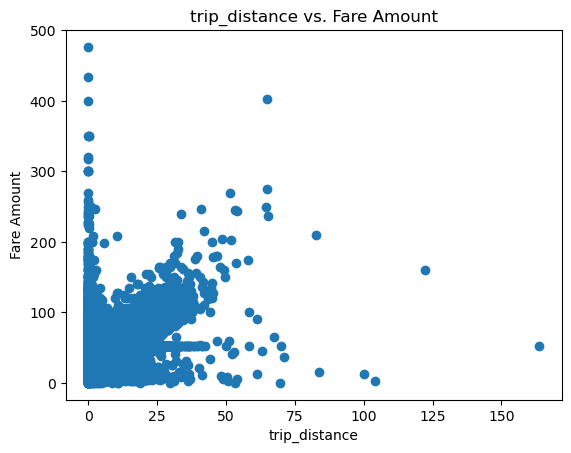

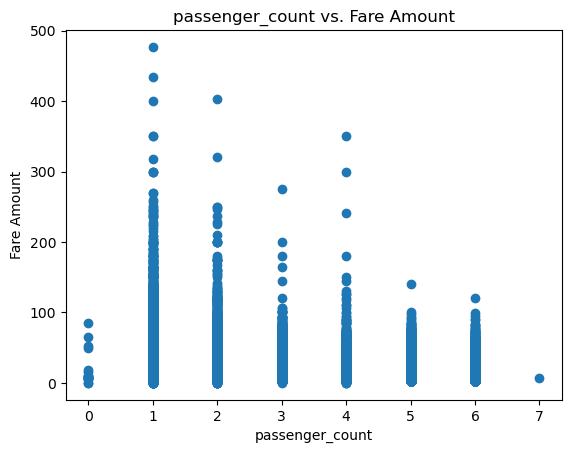

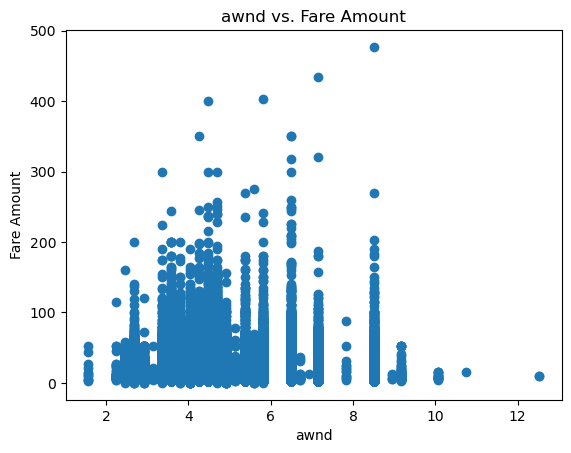

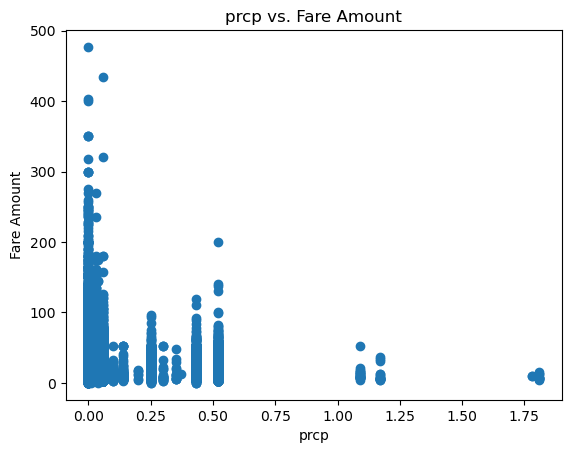

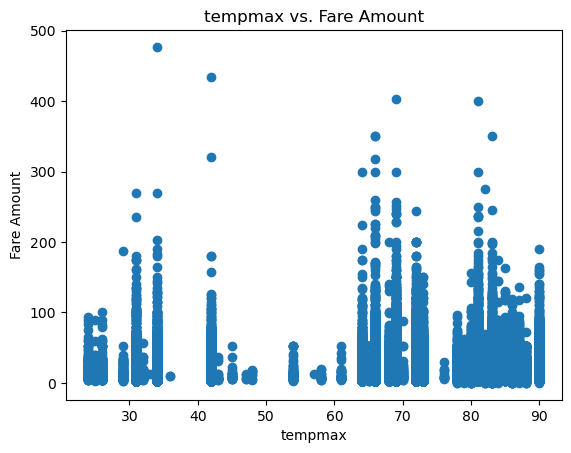

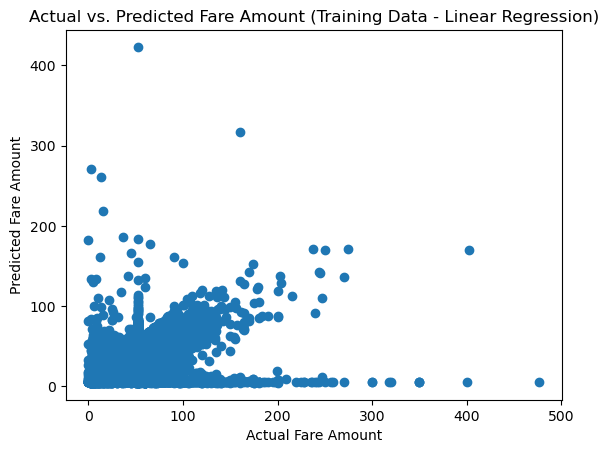

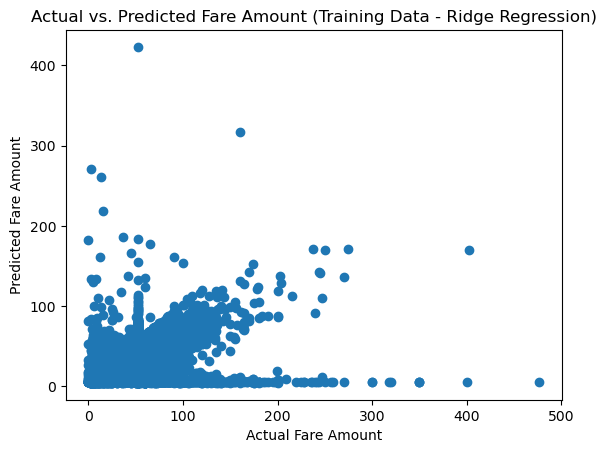

Linear Regression - Mean Squared Error: 32.30602998977815
Linear Regression - R-squared: 0.7094201577694345
Ridge Regression - Mean Squared Error: 32.30603000315209
Ridge Regression - R-squared: 0.7094201576491412


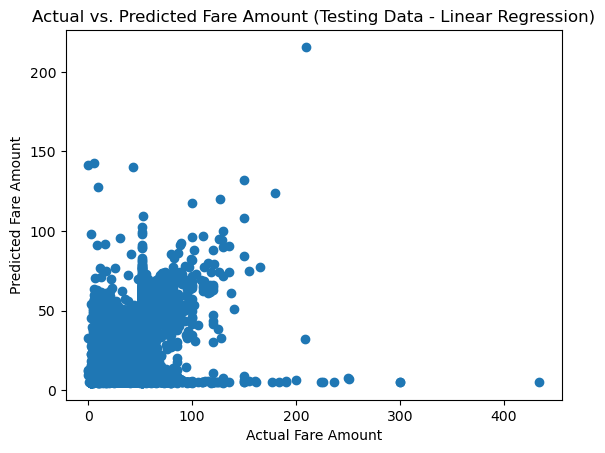

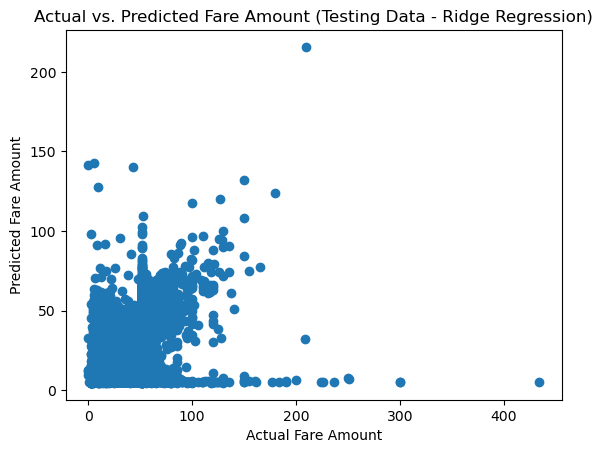

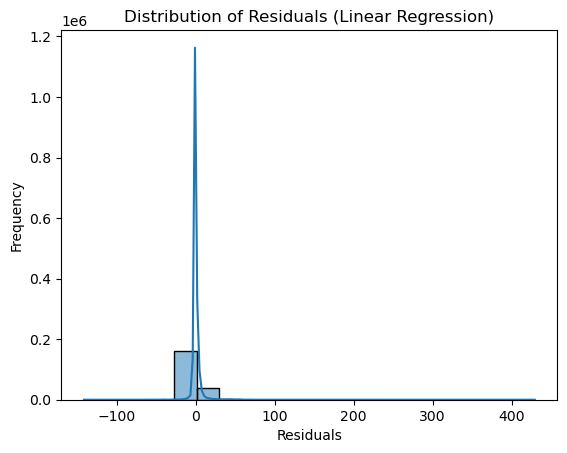

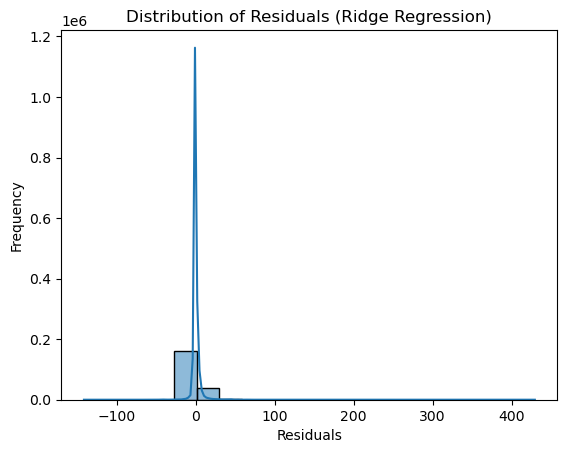

Linear Regression - Average MSE: 32.853135032478264
Linear Regression - Standard Deviation of MSE: 1.8201130541880723
Ridge Regression - Average MSE: 32.85313501815928
Ridge Regression - Standard Deviation of MSE: 1.8201129231932855


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Select features
features = ['trip_distance', 'passenger_count', 'awnd', 'prcp', 'tempmax']
target = 'fare_amount'
X = df[features]
y = df[target]

# Handle missing values (replace with the mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the distribution of the target variable
sns.histplot(y, bins=20, kde=True)
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

# Visualize the relationship between features and target
for i, feature in enumerate(features):
    plt.scatter(X[:, i], y)
    plt.title(f'{feature} vs. Fare Amount')
    plt.xlabel(feature)
    plt.ylabel('Fare Amount')
    plt.show()

# Initialize the models
model = LinearRegression()
ridge_model = Ridge(alpha=0.1)  # Initialize Ridge with alpha=0.1

# Train the models
model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# Visualize the linear model's predictions on the training data
plt.scatter(y_train, model.predict(X_train))
plt.title('Actual vs. Predicted Fare Amount (Training Data - Linear Regression)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

# Visualize the Ridge model's predictions on the training data
plt.scatter(y_train, ridge_model.predict(X_train))
plt.title('Actual vs. Predicted Fare Amount (Training Data - Ridge Regression)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

# Make predictions on the testing data (for both models)
y_pred_linear = model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the linear model
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f'Linear Regression - Mean Squared Error: {mse_linear}')
print(f'Linear Regression - R-squared: {r2_linear}')

# Evaluate the Ridge model
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression - Mean Squared Error: {mse_ridge}')
print(f'Ridge Regression - R-squared: {r2_ridge}')

# Visualize the linear model's predictions on the testing data
plt.scatter(y_test, y_pred_linear)
plt.title('Actual vs. Predicted Fare Amount (Testing Data - Linear Regression)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

# Visualize the Ridge model's predictions on the testing data
plt.scatter(y_test, y_pred_ridge)
plt.title('Actual vs. Predicted Fare Amount (Testing Data - Ridge Regression)')
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.show()

# Visualize the residuals for the linear model
residuals_linear = y_test - y_pred_linear
sns.histplot(residuals_linear, bins=20, kde=True)
plt.title('Distribution of Residuals (Linear Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Visualize the residuals for the Ridge model
residuals_ridge = y_test - y_pred_ridge
sns.histplot(residuals_ridge, bins=20, kde=True)
plt.title('Distribution of Residuals (Ridge Regression)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Perform 5-fold cross-validation on the linear regression model
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the average MSE and its standard deviation
print(f'Linear Regression - Average MSE: {-scores.mean()}')
print(f'Linear Regression - Standard Deviation of MSE: {scores.std()}')

# Perform 5-fold cross-validation on the Ridge regression model
scores_ridge = cross_val_score(ridge_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Print the average MSE and its standard deviation
print(f'Ridge Regression - Average MSE: {-scores_ridge.mean()}')
print(f'Ridge Regression - Standard Deviation of MSE: {scores_ridge.std()}')

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
features = ['trip_distance', 'passenger_count', 'awnd', 'prcp', 'tempmax']
target = 'total_amount'
X = df[features]
y = df[target]

# Handle missing values (replace with the mean)
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree model
tree_model = DecisionTreeRegressor(random_state=42)  # Set random_state for reproducibility

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_tree = tree_model.predict(X_test)

# Evaluate the model
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

print(f'Decision Tree - Mean Squared Error: {mse_tree}')
print(f'Decision Tree - R-squared: {r2_tree}')

Decision Tree - Mean Squared Error: 47.70878852337757
Decision Tree - R-squared: 0.7235110668676882


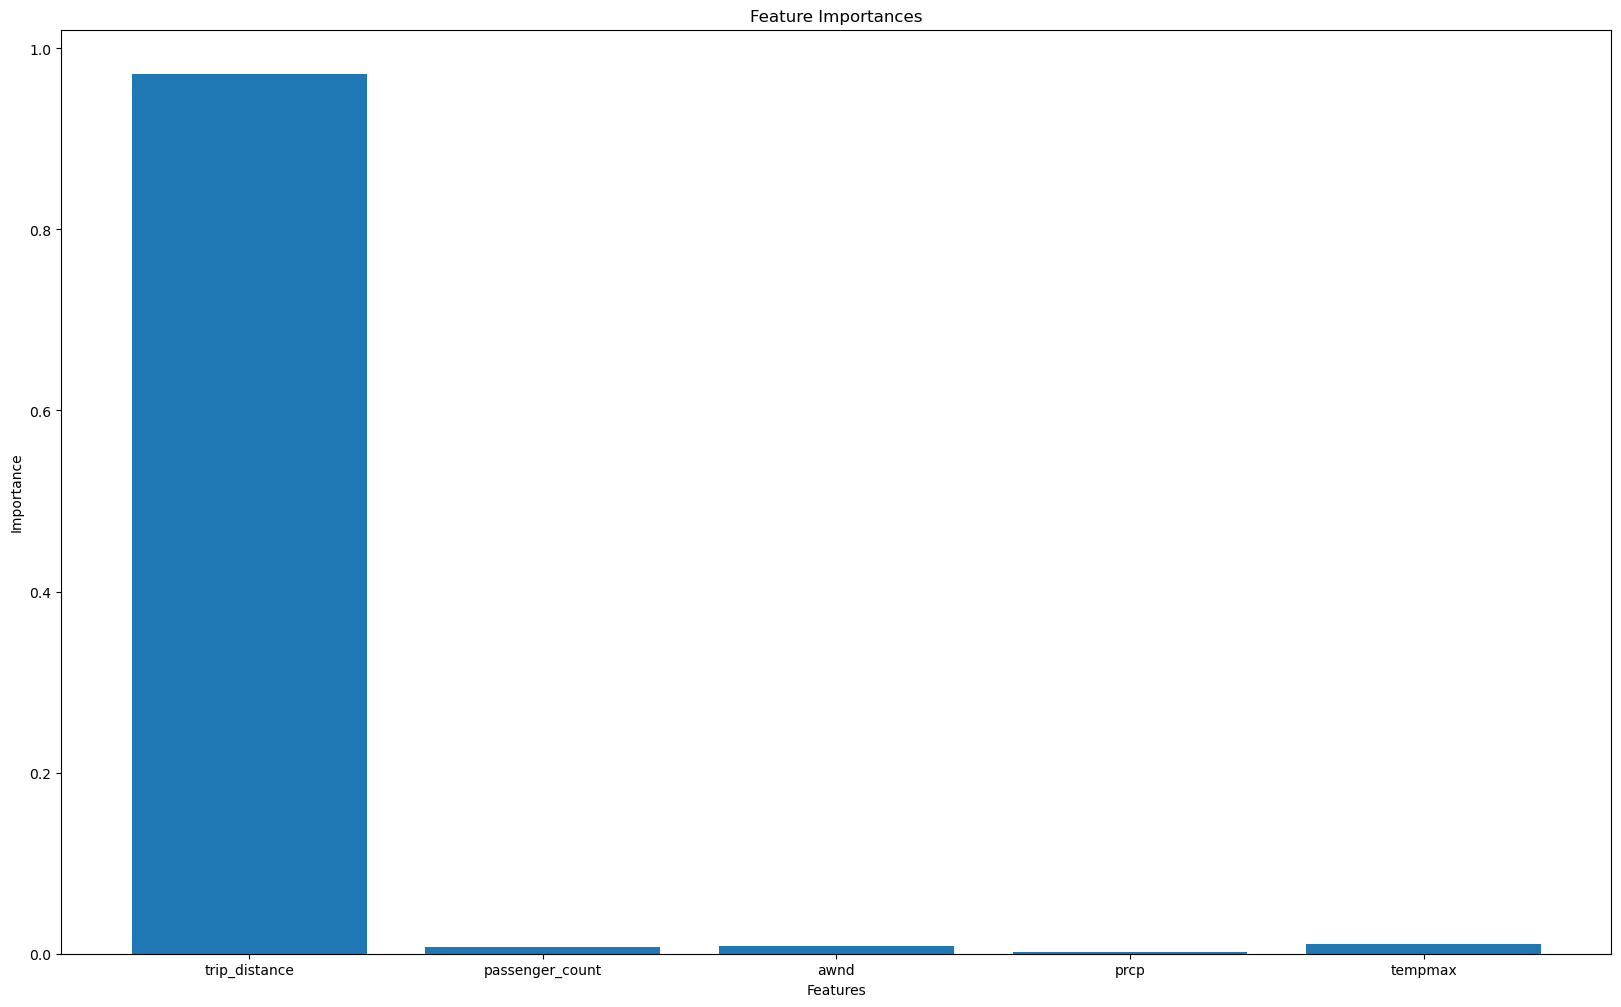

In [28]:
import matplotlib.pyplot as plt

# Get feature importances
importances = tree_model.feature_importances_

# Create a bar chart
plt.figure(figsize=(20, 12))
plt.bar(features, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()